In [30]:
# import library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
import warnings
warnings.filterwarnings('ignore')

## Exploratory Data Analysis

In [2]:
# Importing necessary data
train = pd.read_csv('train.csv', parse_dates = True, low_memory = False, index_col = 'date')
holidays_data = pd.read_csv('holidays_events.csv')
store_data =  pd.read_csv('stores.csv')

In [3]:
print('Number of train samples: ', train.shape)
print('Number of store data: ', store_data.shape)
print('Number of Holiday data: ', holidays_data.shape)
print('Number of Oil Price data: ', oil_data.shape)
print('Number of features: ', len(train.columns))
print(train.info())
print(train.columns)
print(train.head())

Number of train samples:  (3000888, 5)
Number of store data:  (54, 5)
Number of Holiday data:  (350, 6)
Number of Oil Price data:  (1218, 2)
Number of features:  5
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000888 entries, 2013-01-01 to 2017-08-15
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 137.4+ MB
None
Index(['id', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')
            id  store_nbr      family  sales  onpromotion
date                                                     
2013-01-01   0          1  AUTOMOTIVE    0.0            0
2013-01-01   1          1   BABY CARE    0.0            0
2013-01-01   2          1      BEAUTY    0.0            0
2013-01-01   3          1   BEVERAGES    0.0            0
2013-01-01   4          1       B

### EDA for the train data

In [4]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000888 entries, 2013-01-01 to 2017-08-15
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 137.4+ MB


id             0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

##### There is no missing data in the dataframe

In [5]:
# data extraction for each year, month, day and week of the year 
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.isocalendar().week

In [6]:
#merging the data form the store data based on the store number
train_store=train.merge(store_data, on = 'store_nbr', how='left')
train_store.head()

,id,store_nbr,family,sales,onpromotion,Year,Month,Day,WeekOfYear,city,state,type,cluster
0,0,1,AUTOMOTIVE,0.0,0,2013,1,1,1,Quito,Pichincha,D,13
1,1,1,BABY CARE,0.0,0,2013,1,1,1,Quito,Pichincha,D,13
2,2,1,BEAUTY,0.0,0,2013,1,1,1,Quito,Pichincha,D,13
3,3,1,BEVERAGES,0.0,0,2013,1,1,1,Quito,Pichincha,D,13
4,4,1,BOOKS,0.0,0,2013,1,1,1,Quito,Pichincha,D,13


In [7]:
print("In total: ", train_store.shape)

In total:  (3000888, 13)


##### Finding the type of product with the highest number of sales thougout the dataframe

In [8]:
sales_sum_by_family = train.groupby('family')['sales'].sum().reset_index()

# Sort the result by 'sales' in descending order
sales_sum_by_family_sorted = sales_sum_by_family.sort_values(by='sales', ascending=False).reset_index(drop=True)

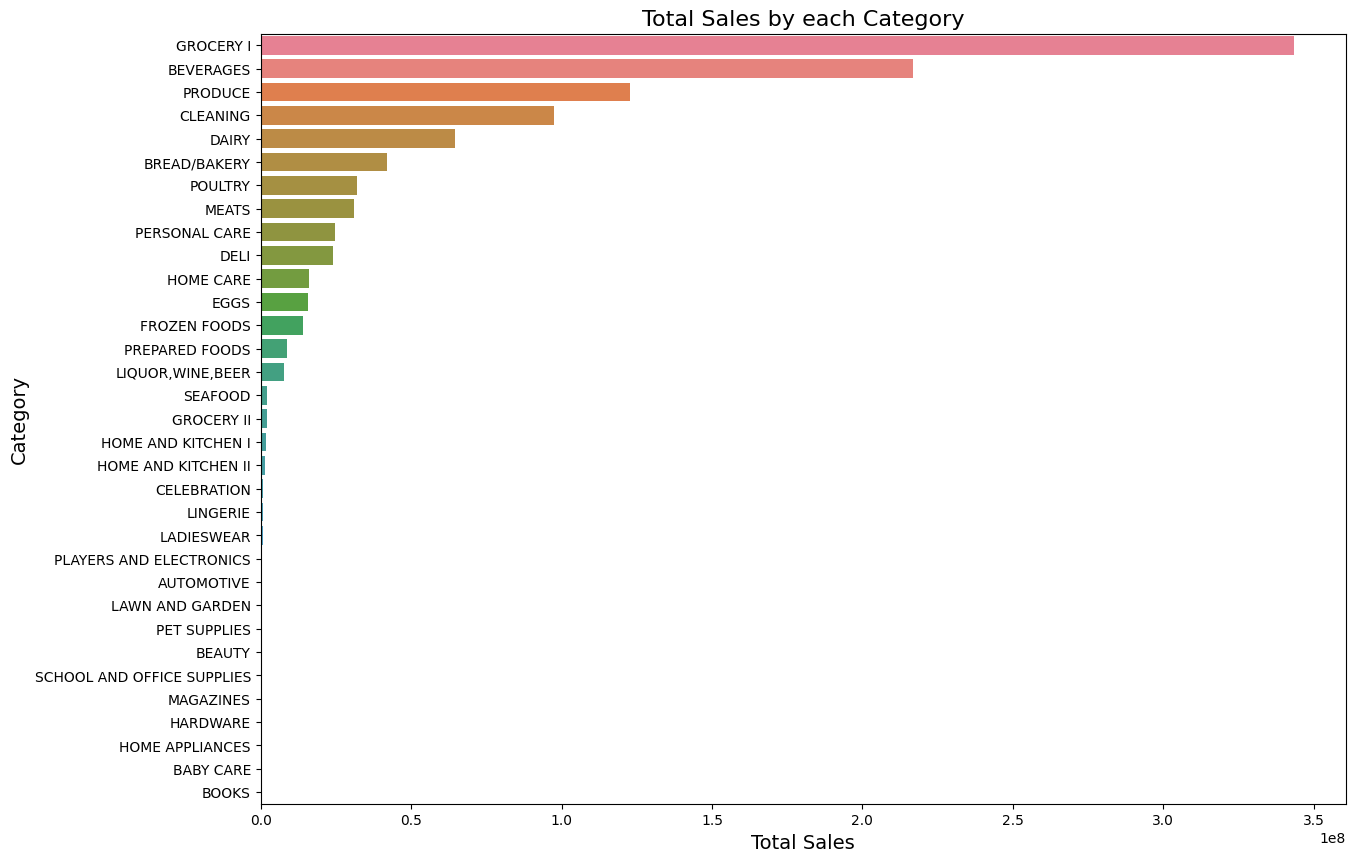

In [9]:
#Ploting the Graph
plt.figure(figsize=(14, 10))
sns.barplot(x="sales", y="family", data=sales_sum_by_family_sorted, hue='family')
# Add labels and title
plt.title("Total Sales by each Category", fontsize=16)
plt.xlabel("Total Sales", fontsize=14)
plt.ylabel("Category", fontsize=14)
plt.show()

In [10]:
sales_sum_by_family_sorted ['sales'] = sales_sum_by_family_sorted ['sales'].apply(lambda x: '{:.2f}'.format(x))

# Display the result
print(sales_sum_by_family_sorted)

                        family         sales
0                    GROCERY I  343462734.89
1                    BEVERAGES  216954486.00
2                      PRODUCE  122704684.68
3                     CLEANING   97521289.00
4                        DAIRY   64487709.00
5                 BREAD/BAKERY   42133945.58
6                      POULTRY   31876004.47
7                        MEATS   31086468.40
8                PERSONAL CARE   24592051.00
9                         DELI   24110322.47
10                   HOME CARE   16022744.00
11                        EGGS   15588296.00
12                FROZEN FOODS   14073887.72
13              PREPARED FOODS    8799895.12
14            LIQUOR,WINE,BEER    7746640.00
15                     SEAFOOD    2015431.88
16                  GROCERY II    1962767.00
17          HOME AND KITCHEN I    1861491.00
18         HOME AND KITCHEN II    1520670.00
19                 CELEBRATION     761177.00
20                    LINGERIE     653114.00
21        

##### The highest number of sales is from the GROCERY I cetogory with a total sales of 343462734.89 while the lowest sales is in the BOOKS category with only 6438.00 of total sales.
##### Finding the store with the highest number of sales thougout the dataframe

In [11]:
# Calculate sum of sales by store
sales_sum_by_store = train.groupby("store_nbr")['sales'].sum().reset_index()

# Sort the result by 'sales' in descending order
sales_sum_by_store_sorted = sales_sum_by_store.sort_values(by='sales', ascending=False).reset_index(drop=True)

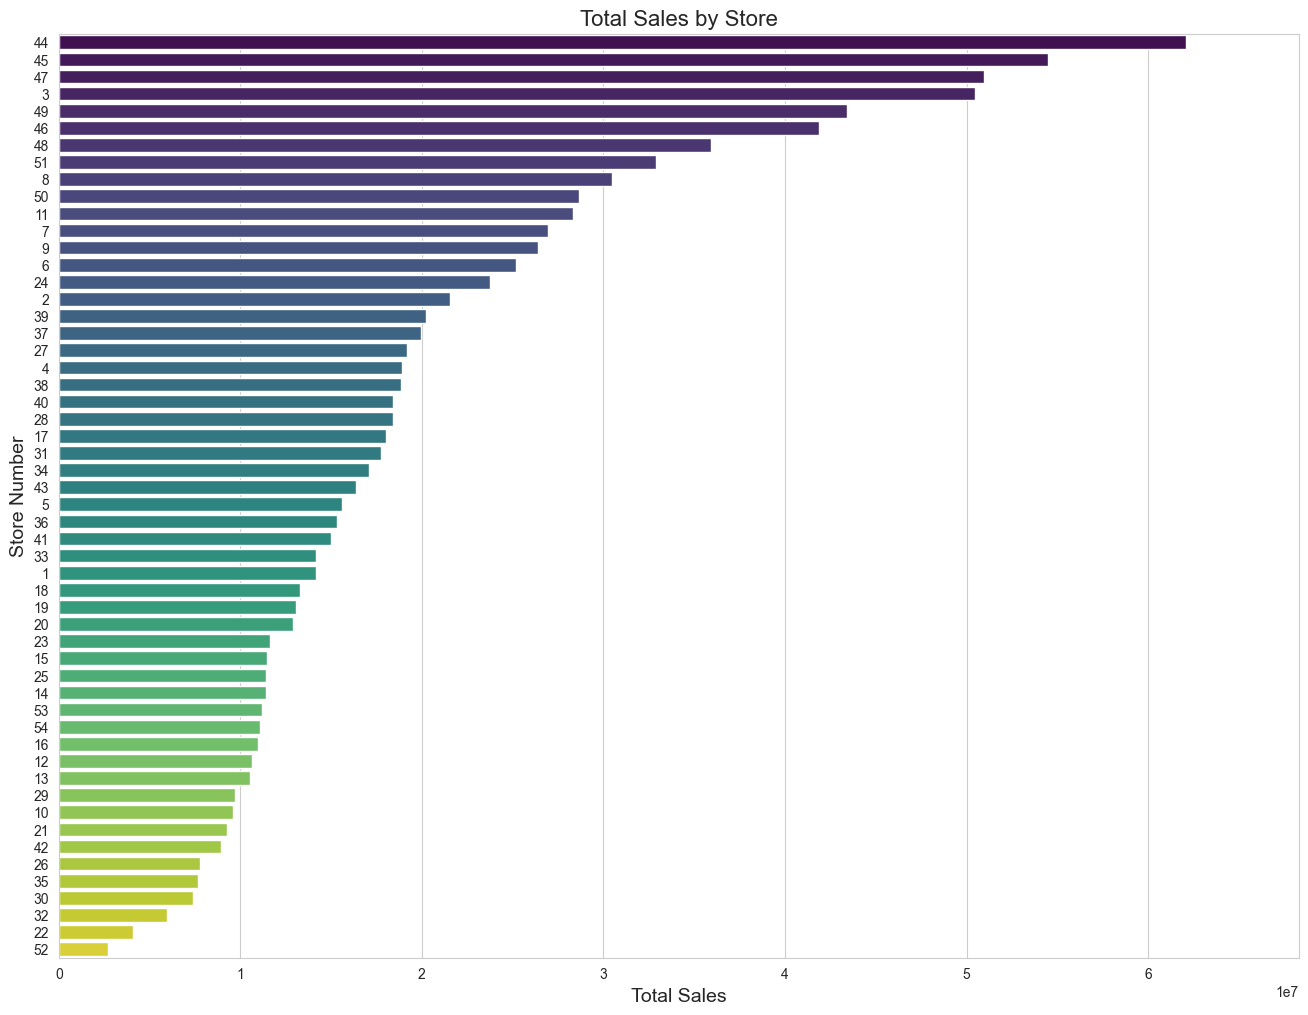

In [12]:
# Plotting the Graph
plt.figure(figsize=(16, 12))

# Set style for the plot
sns.set_style("whitegrid")

# Create a barplot using Seaborn, ensuring store numbers are ordered by sales
barplot = sns.barplot(
    x="sales",
    y="store_nbr",
    data=sales_sum_by_store_sorted,
    palette="viridis",
    orient='h',
    order=sales_sum_by_store_sorted['store_nbr']  # Ensure order by sales
)

# Add labels and title
plt.title("Total Sales by Store", fontsize=16)
plt.xlabel("Total Sales", fontsize=14)
plt.ylabel("Store Number", fontsize=14)


# Adjust plot margins to prevent clipping
plt.xlim(0, max(sales_sum_by_store_sorted['sales']) * 1.1)

# Show the plot
plt.show()

In [13]:
# Display the sorted sales by store
sales_sum_by_store_sorted['sales'] = sales_sum_by_store_sorted ['sales'].apply(lambda x: '{:.2f}'.format(x))
print(sales_sum_by_store_sorted)

    store_nbr        sales
0          44  62087553.25
1          45  54498010.42
2          47  50948310.06
3           3  50481910.19
4          49  43420095.78
5          46  41896062.12
6          48  35933130.27
7          51  32911489.54
8           8  30494286.93
9          50  28653020.62
10         11  28325558.48
11          7  26952049.58
12          9  26409441.06
13          6  25183680.00
14         24  23767732.70
15          2  21557388.64
16         39  20252192.53
17         37  19970635.61
18         27  19188021.38
19          4  18909700.38
20         38  18859999.26
21         40  18395757.41
22         28  18383154.83
23         17  18030969.25
24         31  17746872.70
25         34  17090734.16
26         43  16391692.21
27          5  15592404.57
28         36  15322431.10
29         41  14991039.14
30         33  14178501.29
31          1  14145012.87
32         18  13259375.69
33         19  13049509.84
34         20  12920954.59
35         23  11651380.67
3

##### The highest number of sales is from the store number 44 with a total sales of 62087553.25 while the lowest sales is from the store number 53 a total sales of 2696169.73.

### EDA for holidays data

In [14]:
holidays_data.info()
holidays_data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

##### There is no missing data in the holidays dataframe

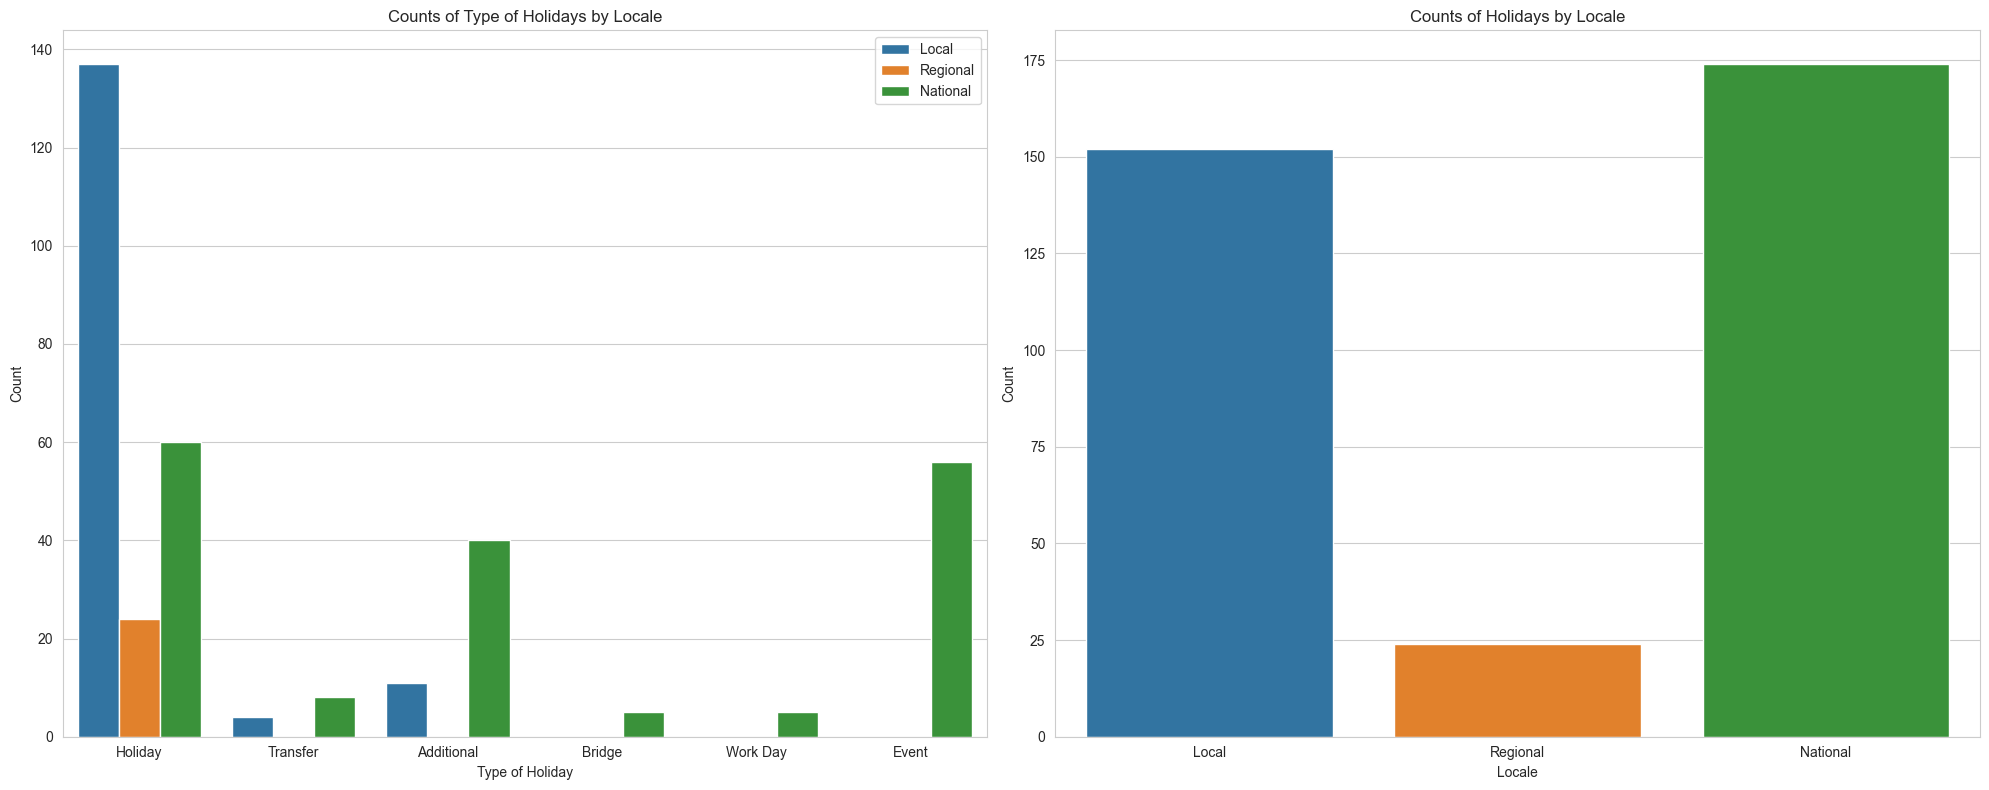

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Counts of Types of Holidays by Locale
axes[0].set_title('Counts of Type of Holidays by Locale')
sns.countplot(ax=axes[0], x=holidays_data['type'], hue=holidays_data['locale'])
axes[0].set_xlabel('Type of Holiday')
axes[0].set_ylabel('Count')
axes[0].legend(loc='upper right')


# Plot 2: Counts of Holidays by Locale
axes[1].set_title('Counts of Holidays by Locale')
sns.countplot(ax=axes[1], x=holidays_data['locale'], hue=holidays_data['locale'])
axes[1].set_xlabel('Locale')
axes[1].set_ylabel('Count')


# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

##### Based on the graph Local Holiday has the highest amount of counts of type of Holidays by Locale, and the highest counts Holidays by Locale is National. 
### EDA for stores data

In [16]:
store_data.info()
store_data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

##### There is no missing data inside the dataframe

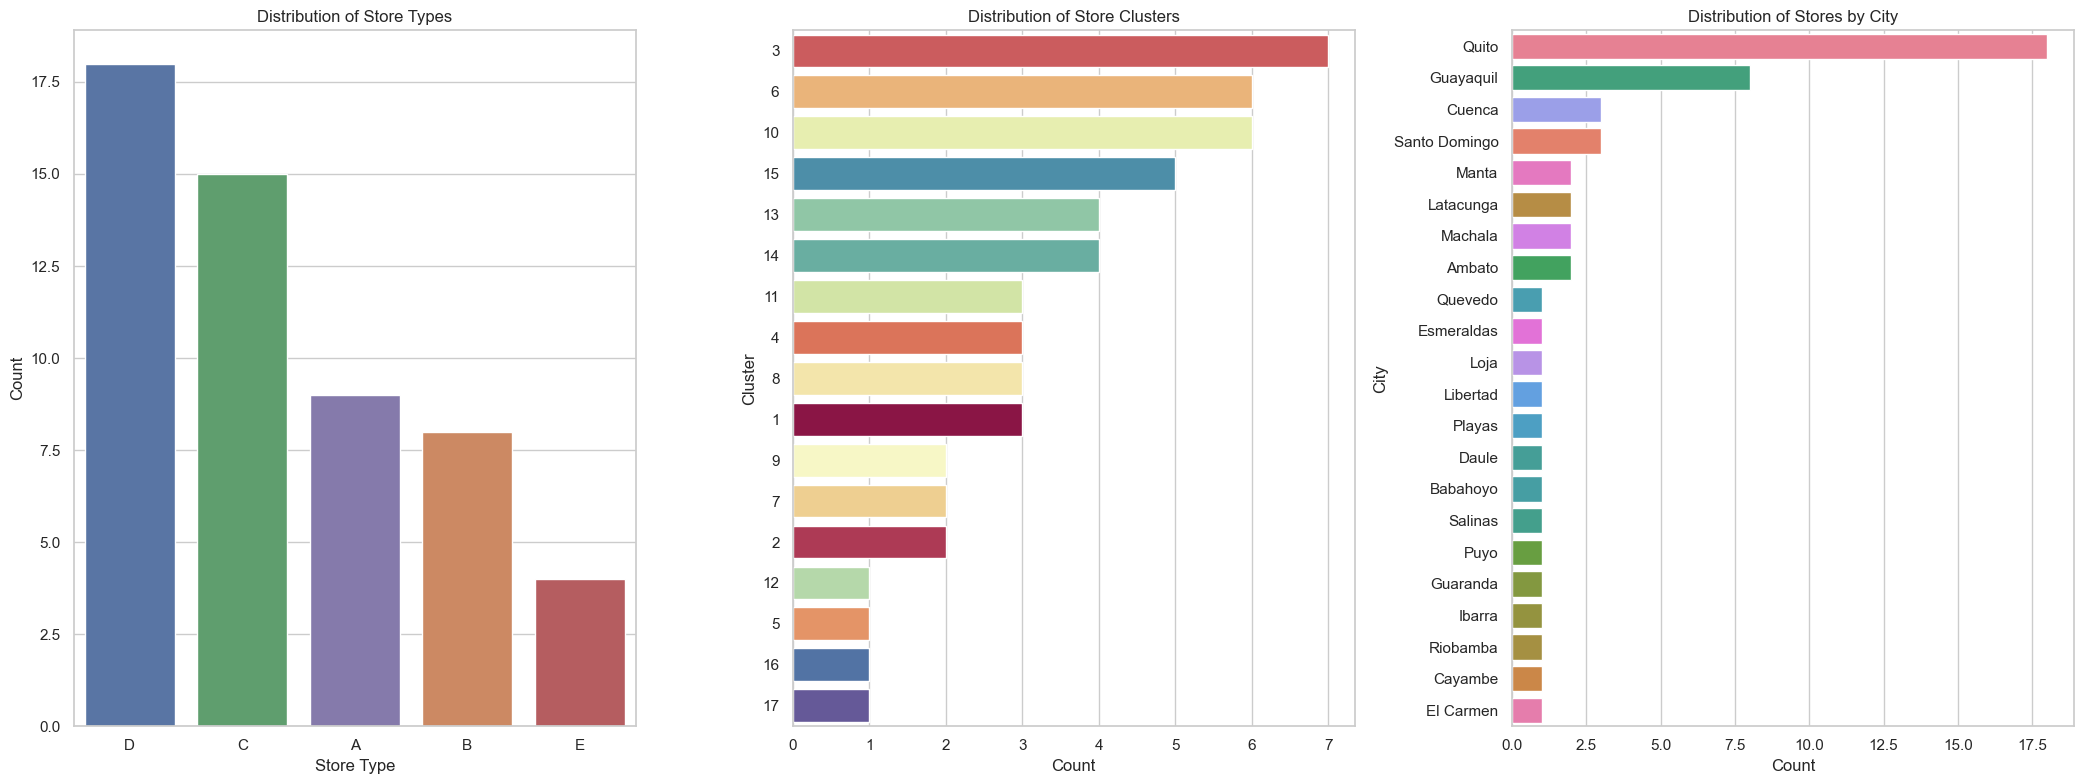

In [17]:
# Set a consistent style for the plots
sns.set(style="whitegrid")

# Create a 1x3 grid for subplots with a larger figsize for better visualization
fig, axes = plt.subplots(1, 3, figsize=(21, 8))

# Define a color palette 
palette = sns.color_palette("Spectral", as_cmap=True)

# Plot 1: Distribution of Store Types
axes[0].set_title('Distribution of Store Types')
sns.countplot(ax=axes[0], x=store_data['type'], order=store_data['type'].value_counts().index,  hue=store_data['type'])
axes[0].set_xlabel('Store Type')
axes[0].set_ylabel('Count')

# Plot 2: Distribution of Store Clusters
axes[1].set_title('Distribution of Store Clusters')
sns.countplot(ax=axes[1], y=store_data['cluster'], order=store_data['cluster'].value_counts().index, hue=store_data['cluster'], legend=False, palette=palette)
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Cluster')
axes[1].tick_params(axis='y')

# Plot 3: Distribution of Stores by City
axes[2].set_title('Distribution of Stores by City')
sns.countplot(ax=axes[2], y=store_data['city'], order=store_data['city'].value_counts().index, hue=store_data['city'])
axes[2].set_xlabel('Count')
axes[2].set_ylabel('City')
axes[2].tick_params(axis='y')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

##### Type A is the most prominant type of store, while the cluster 3 is the most dominant cluster. The city Quito is the city with the most number of store.

In [18]:
# For counting unique cities and types per state, 
result = train_store.groupby('state').agg({
    'city': 'nunique',   # Number of unique cities per state
    'type': 'nunique',   # Number of unique types per state
    'sales': 'sum'       # Sum of sales per state
}).reset_index()

# Rename columns for clarity
result.rename(columns={'city': 'unique_cities', 'type': 'unique_types'}, inplace=True)

# Display the result
print(result)

                             state  unique_cities  unique_types         sales
0                            Azuay              1             2  4.916860e+07
1                          Bolivar              1             1  1.304951e+07
2                       Chimborazo              1             1  1.138792e+07
3                         Cotopaxi              1             1  2.118226e+07
4                           El Oro              1             2  3.338680e+07
5                       Esmeraldas              1             1  1.639169e+07
6                           Guayas              4             5  1.651544e+08
7                         Imbabura              1             1  1.145127e+07
8                             Loja              1             1  1.886000e+07
9                         Los Rios              2             2  3.192537e+07
10                          Manabi              2             3  2.496982e+07
11                         Pastaza              1             1 

##### The Azuay state have the most number of sales which is 49168600. The highest number uniques cities and uniques types is Guayas city with 4 and 5 number of uniques cities and uniques types respectively.
## Time Series Forecasting
##### For forecasting, we will forecast the store number 44 since it is the higest grossing sales througout the dataframe.

In [31]:
train=train.reset_index()
# Get the sales for the store number 44
sales = train[train.store_nbr == 44].loc[:, ['date', 'sales']]

sales = sales.sort_index(ascending = False)

# Change to  datetime64
sales['date'] = pd.DatetimeIndex(sales['date'])
sales.dtypes

# rename for the prophet library
sales = sales.rename(columns = {'date': 'ds',
                                'sales': 'y'})
sales.head()

,ds,y
3000392,2017-08-15,80.240
3000391,2017-08-15,345.000
3000390,2017-08-15,7239.617
3000389,2017-08-15,329.522
3000388,2017-08-15,909.194


In [32]:
# create the holidays dataframe
state_dates = holidays_data[((holidays_data.locale == 'National') |
                             (holidays_data.locale == 'Regional') &
                             (holidays_data.type == 'Holiday'))].loc[:, 'date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
holidays = state      
holidays.head()

,holiday,ds
0,state_holiday,2012-04-01
1,state_holiday,2012-06-25
2,state_holiday,2012-08-10
3,state_holiday,2012-10-09
4,state_holiday,2012-10-12


In [34]:
# set the uncertainty interval to 95% 
model = Prophet(interval_width = 0.95, 
                   holidays = holidays)
model.fit(sales)

# dataframe that extends into future 52 weeks (1 years)
future_dates = model.make_future_dataframe(periods = 52*7)


20:47:39 - cmdstanpy - INFO - Chain [1] start processing
20:47:49 - cmdstanpy - INFO - Chain [1] done processing


In [35]:
forecast = model.predict(future_dates)

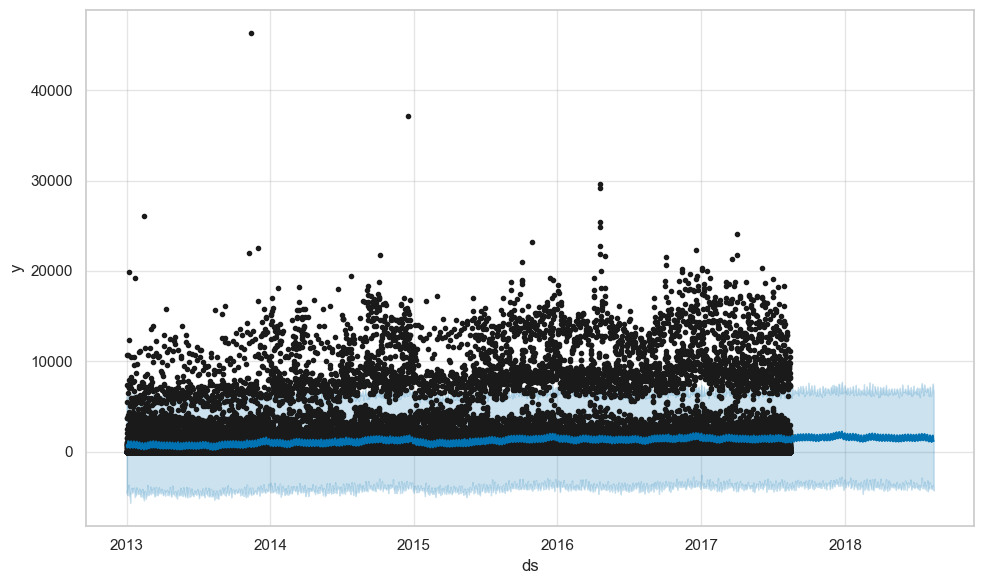

In [36]:
fig1 = model.plot(forecast)

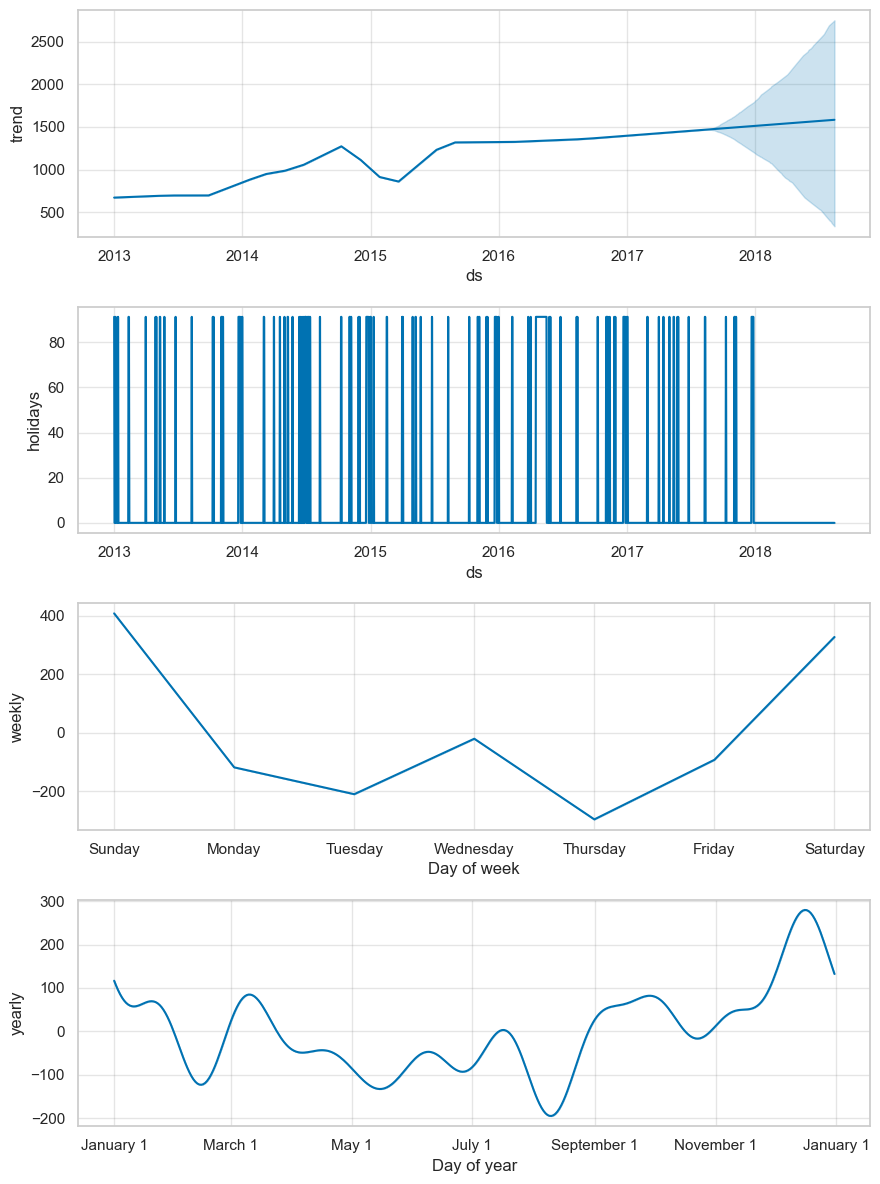

In [37]:
# Plotting components
fig2 = model.plot_components(forecast)

In [25]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,669.869894,-4462.476018,5950.984396,669.869894,669.869894,-1.363804,-1.363804,-1.363804,91.236695,...,-209.294864,-209.294864,-209.294864,116.694366,116.694366,116.694366,0.0,0.0,0.0,668.506090
1,2013-01-02,670.043546,-4236.328281,5979.149461,670.043546,670.043546,85.110367,85.110367,85.110367,0.000000,...,-20.125250,-20.125250,-20.125250,105.235617,105.235617,105.235617,0.0,0.0,0.0,755.153912
2,2013-01-03,670.217197,-4824.397931,5706.764441,670.217197,670.217197,-200.455670,-200.455670,-200.455670,0.000000,...,-295.314941,-295.314941,-295.314941,94.859271,94.859271,94.859271,0.0,0.0,0.0,469.761527
3,2013-01-04,670.390849,-4619.538555,5758.350827,670.390849,670.390849,-6.378137,-6.378137,-6.378137,0.000000,...,-92.062184,-92.062184,-92.062184,85.684047,85.684047,85.684047,0.0,0.0,0.0,664.012711
4,2013-01-05,670.564500,-4673.995369,6207.116350,670.564500,670.564500,496.065317,496.065317,496.065317,91.236695,...,327.034542,327.034542,327.034542,77.794080,77.794080,77.794080,0.0,0.0,0.0,1166.629817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,2018-08-10,1582.461743,-4075.070241,6632.470160,438.210422,2758.840718,-286.740356,-286.740356,-286.740356,0.000000,...,-92.062184,-92.062184,-92.062184,-194.678172,-194.678172,-194.678172,0.0,0.0,0.0,1295.721387
2044,2018-08-11,1582.778275,-3454.259036,7250.086439,437.262693,2763.840749,133.485292,133.485292,133.485292,0.000000,...,327.034542,327.034542,327.034542,-193.549250,-193.549250,-193.549250,0.0,0.0,0.0,1716.263567
2045,2018-08-12,1583.094807,-3382.955098,7024.564201,432.415301,2768.840779,216.867505,216.867505,216.867505,0.000000,...,407.494935,407.494935,407.494935,-190.627430,-190.627430,-190.627430,0.0,0.0,0.0,1799.962312
2046,2018-08-13,1583.411339,-3611.865251,6686.592424,427.058907,2773.840810,-303.697472,-303.697472,-303.697472,0.000000,...,-117.732238,-117.732238,-117.732238,-185.965234,-185.965234,-185.965234,0.0,0.0,0.0,1279.713867


In [27]:
new = forecast[forecast['ds'] >= '2017-08-16']

In [28]:
new1 = new[new['ds'] <= '2017-08-31']

##### The prediction for the 2 next two weeks after the dataframe for the store number 44

In [29]:
new1

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1684,2017-08-16,1468.826756,-3708.367675,6231.197409,1468.826756,1468.826756,-180.126859,-180.126859,-180.126859,0.0,...,-20.125250,-20.125250,-20.125250,-160.001609,-160.001609,-160.001609,0.0,0.0,0.0,1288.699897
1685,2017-08-17,1469.143288,-4267.262099,5956.209695,1469.143288,1469.143288,-444.525718,-444.525718,-444.525718,0.0,...,-295.314941,-295.314941,-295.314941,-149.210778,-149.210778,-149.210778,0.0,0.0,0.0,1024.617570
1686,2017-08-18,1469.459820,-3834.410070,6920.743897,1469.459820,1469.496507,-229.468189,-229.468189,-229.468189,0.0,...,-92.062184,-92.062184,-92.062184,-137.406005,-137.406005,-137.406005,0.0,0.0,0.0,1239.991631
1687,2017-08-19,1469.776352,-3673.512180,6307.244290,1469.692865,1469.950463,202.249625,202.249625,202.249625,0.0,...,327.034542,327.034542,327.034542,-124.784918,-124.784918,-124.784918,0.0,0.0,0.0,1672.025976
1688,2017-08-20,1470.092884,-3172.933171,6965.274382,1469.678303,1470.767758,295.941402,295.941402,295.941402,0.0,...,407.494935,407.494935,407.494935,-111.553533,-111.553533,-111.553533,0.0,0.0,0.0,1766.034286
1689,2017-08-21,1470.409416,-3654.534328,6510.116575,1469.419530,1471.556100,-215.653684,-215.653684,-215.653684,0.0,...,-117.732238,-117.732238,-117.732238,-97.921446,-97.921446,-97.921446,0.0,0.0,0.0,1254.755732
1690,2017-08-22,1470.725948,-3628.971058,6384.418240,1469.324950,1472.549154,-293.391909,-293.391909,-293.391909,0.0,...,-209.294864,-209.294864,-209.294864,-84.097045,-84.097045,-84.097045,0.0,0.0,0.0,1177.334039
1691,2017-08-23,1471.042480,-4267.916748,6349.171910,1469.130718,1473.152808,-90.408102,-90.408102,-90.408102,0.0,...,-20.125250,-20.125250,-20.125250,-70.282852,-70.282852,-70.282852,0.0,0.0,0.0,1380.634378
1692,2017-08-24,1471.359012,-3406.644581,5982.270236,1468.893281,1474.294528,-351.986070,-351.986070,-351.986070,0.0,...,-295.314941,-295.314941,-295.314941,-56.671129,-56.671129,-56.671129,0.0,0.0,0.0,1119.372942
1693,2017-08-25,1471.675544,-4177.549897,6396.951892,1468.396562,1475.429976,-135.502028,-135.502028,-135.502028,0.0,...,-92.062184,-92.062184,-92.062184,-43.439843,-43.439843,-43.439843,0.0,0.0,0.0,1336.173516
